## Import Data

In [99]:
import pandas as pd

df = pd.ExcelFile("WBA.xlsx").parse("Absorbance")

In [100]:
df.rename(columns={"Unnamed: 15": "EthFinal", "Unnamed: 19": "LangFinal"}, inplace=True)

In [101]:
df_long = pd.melt(df, id_vars=['Subject','Gender','DOT','DOB','AgeY','EthFinal','LangFinal','PTAAv4FAPoFC','TympPoF','OAEPoFC','OverallPoF','EarSide'], value_vars=['f(226.0000)','f(226.0000)','f(257.3256)','f(280.6155)','f(297.3018)','f(324.2099)','f(343.4884)','f(363.9133)','f(385.5527)','f(408.4789)','f(432.7683)','f(458.5020)','f(471.9372)','f(500.0000)','f(514.6511)','f(545.2539)','f(561.2310)','f(577.6763)','f(594.6036)','f(629.9605)','f(648.4198)','f(667.4199)','f(686.9768)','f(707.1068)','f(727.8266)','f(749.1535)','f(771.1054)','f(793.7005)','f(816.9577)','f(840.8964)','f(865.5366)','f(890.8987)','f(917.0040)','f(943.8743)','f(971.5319)','f(1000.0000)','f(1029.3022)','f(1059.4631)','f(1090.5077)','f(1122.4620)','f(1155.3527)','f(1189.2071)','f(1224.0535)','f(1259.9210)','f(1296.8396)','f(1334.8399)','f(1373.9536)','f(1414.2136)','f(1455.6532)','f(1498.3071)','f(1542.2108)','f(1587.4011)','f(1633.9155)','f(1681.7928)','f(1731.0731)','f(1781.7974)','f(1834.0081)','f(1887.7486)','f(1943.0639)','f(2000.0000)','f(2058.6045)','f(2118.9262)','f(2181.0155)','f(2244.9241)','f(2310.7054)','f(2378.4142)','f(2448.1071)','f(2519.8421)','f(2593.6791)','f(2669.6797)','f(2747.9073)','f(2828.4271)','f(2911.3064)','f(2996.6142)','f(3084.4217)','f(3174.8021)','f(3267.8309)','f(3363.5857)','f(3462.1462)','f(3563.5949)','f(3668.0162)','f(3775.4973)','f(3886.1278)','f(4000.0000)','f(4117.2089)','f(4237.8524)','f(4362.0309)','f(4489.8482)','f(4621.4108)','f(4756.8285)','f(4896.2142)','f(5039.6842)','f(5187.3582)','f(5339.3594)','f(5495.8146)','f(5656.8542)','f(5822.6127)','f(5993.2283)','f(6168.8433)','f(6349.6042)','f(6535.6618)','f(6727.1713)','f(6924.2925)','f(7127.1897)','f(7336.0323)','f(7550.9945)','f(7772.2555)','f(8000.0000)'],var_name='Frequency', value_name='WBA')
df_long["Frequency"] = df_long["Frequency"].str[2:-1].astype(float)
df_long["WBA"] = df_long["WBA"].astype(float)
df_long = df_long[df_long["OverallPoF"]==0]
df_long = df_long.iloc[0:-35,:]

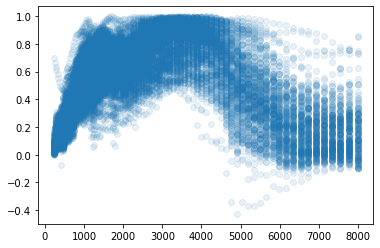

In [102]:
import matplotlib.pyplot as plt

plt.scatter(df_long["Frequency"], df_long["WBA"], alpha=0.1)
plt.show()

## GAN Model

In [103]:
import torch
from torch import nn

import math
import matplotlib.pyplot as plt

torch.manual_seed(111)

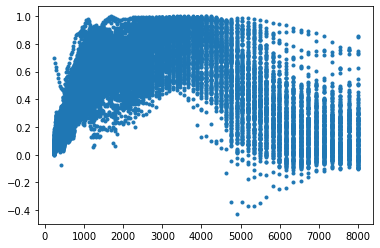

In [104]:
train_data_length = len(df_long) # 21,507 rows

train_data = torch.tensor(df_long[["Frequency","WBA"]].values, dtype=torch.float32)

train_labels = torch.zeros(train_data_length)
train_set = [
    (train_data[i], train_labels[i]) for i in range(train_data_length)
]

plt.plot(train_data[:, 0], train_data[:, 1], ".")

In [105]:
train_data.dtype

torch.float32

In [106]:
batch_size = 32
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, shuffle=True
)

In [107]:
class Discriminator(nn.Module):
  def __init__(self):
    super().__init__()
    self.model = nn.Sequential(
        nn.Linear(2, 256),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(256, 128),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(128, 64),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(64, 1),
        nn.Sigmoid(),
    )

  def forward(self, x):
    output = self.model(x)
    return output

discriminator = Discriminator()

In [108]:
class Generator(nn.Module):
  def __init__(self):
    super().__init__()
    self.model = nn.Sequential(
        nn.Linear(2, 16),
        nn.ReLU(),
        nn.Linear(16, 32),
        nn.ReLU(),
        nn.Linear(32, 2),
    )
  
  def forward(self, x):
    output = self.model(x)
    return output

generator = Generator()

In [113]:
lr = 0.001
num_epochs = 20
loss_function = nn.BCELoss()

optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)

In [114]:
for epoch in range(num_epochs): # 1 min per 10 epochs
  for n, (real_samples, _) in enumerate(train_loader):

    # Data for training the discriminator
    real_samples_labels = torch.ones((batch_size, 1))
    latent_space_samples = torch.randn((batch_size, 2))
    generated_samples = generator(latent_space_samples)
    generated_samples_labels = torch.zeros((batch_size, 1))
    all_samples = torch.cat((real_samples, generated_samples))
    all_samples_labels = torch.cat((real_samples_labels, generated_samples_labels))

    # Training the discriminator
    discriminator.zero_grad()
    output_discriminator = discriminator(all_samples)
    loss_discriminator = loss_function(output_discriminator, all_samples_labels)
    loss_discriminator.backward()
    optimizer_discriminator.step()

    # Data for training the generator
    latent_space_samples = torch.randn((batch_size, 2))

    # Training the generator
    generator.zero_grad()
    generated_samples = generator(latent_space_samples)
    output_discriminator_generated = discriminator(generated_samples)
    loss_generator = loss_function(output_discriminator_generated, real_samples_labels)
    loss_generator.backward()
    optimizer_generator.step()

    # Show loss
    if epoch % 10 == 0 and n == batch_size - 1:
      print(f"Epoch: {epoch} Loss D.: {loss_discriminator}")
      print(f"Epoch: {epoch} Loss G.: {loss_generator}")

Epoch: 0 Loss D.: 0.6931472420692444
Epoch: 0 Loss G.: 0.6935372948646545
Epoch: 10 Loss D.: 0.6823181509971619
Epoch: 10 Loss G.: 0.6936277747154236


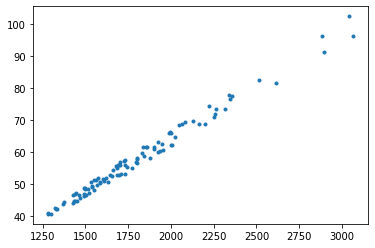

In [115]:
latent_space_samples = torch.randn(100, 2)
generated_samples = generator(latent_space_samples)
generated_samples = generated_samples.detach()
plt.plot(generated_samples[:, 0], generated_samples[:, 1], ".")